In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
%matplotlib inline
import warnings
warnings.simplefilter(action='ignore', category=Warning)

In [2]:
# display 2016_stock_data.csv as dataframe
stock_df = pd.read_csv(
    Path("2016_stock_data.csv"), index_col="Date", infer_datetime_format=True, parse_dates=True)
stock_df.head()

,AMZN,AAPL,NFLX
Date,,,
2016-04-04,593.190002,25.877037,104.349998
2016-04-05,586.140015,25.571972,104.940002
2016-04-06,602.080017,25.839775,104.830002
2016-04-07,591.429993,25.276215,104.449997
2016-04-08,594.599976,25.304159,103.809998


In [3]:
# Create a series using "Price" percentage returns, normalize daily pct change, drop any nan"s, and check the results:
amzn_df = stock_df.loc[:,["AMZN"]]
amzn_daily_returns = stock_df.AMZN.pct_change() * 100
amzn_df["Return"] = np.log(amzn_daily_returns + 100)
amzn_df = amzn_df.replace(-np.inf, np.nan).dropna()
amzn_df.head()

,AMZN,Return
Date,,
2016-04-05,586.140015,4.593214
2016-04-06,602.080017,4.632002
2016-04-07,591.429993,4.587323
2016-04-08,594.599976,4.610516
2016-04-11,595.929993,4.607405


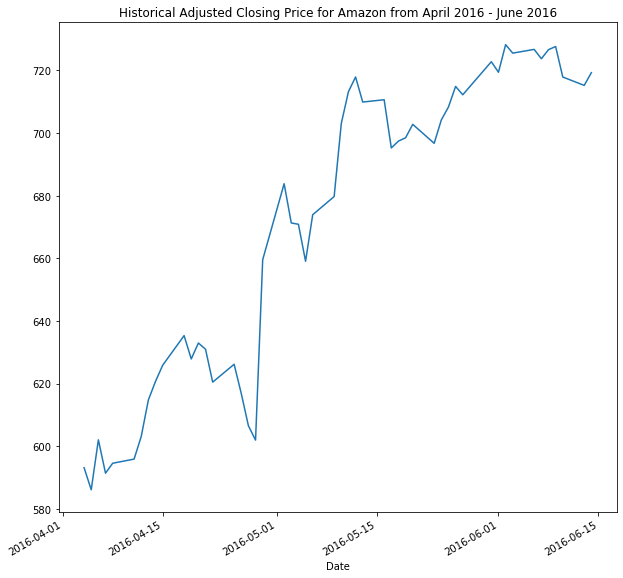

In [4]:
# plot historical adj close price for Amazon
AMZN_plot = stock_df.AMZN.plot(title="Historical Adjusted Closing Price for Amazon from April 2016 - June 2016", figsize=(10,10))

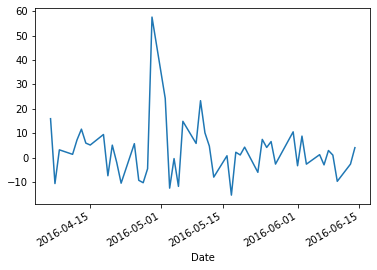

In [5]:
# Differencing AMZN adj close price stationarizes the time series
amzn_df.AMZN.diff().plot()

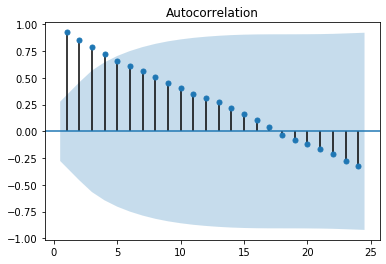

In [6]:
# Plot the autocorrelation of AMZN adj close prices
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(amzn_df.AMZN, zero=False, lags=24);

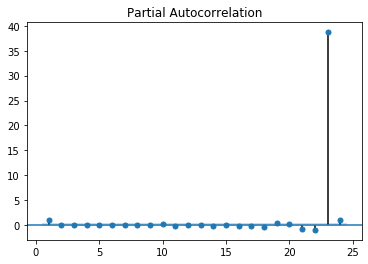

In [7]:
# Plot the partial autocorrelation of the AMZN adj close price
plot_pacf(amzn_df.AMZN, zero=False, lags=24);

In [8]:
# Create a lagged return using the shift function
amzn_lag_return = amzn_df["Return"].shift()
amzn_df["Lagged Return"] = amzn_lag_return
amzn_df = amzn_df.replace(-np.inf, np.nan).dropna()
amzn_df.head()

,AMZN,Return,Lagged Return
Date,,,
2016-04-06,602.080017,4.632002,4.593214
2016-04-07,591.429993,4.587323,4.632002
2016-04-08,594.599976,4.610516,4.587323
2016-04-11,595.929993,4.607405,4.610516
2016-04-12,603.169983,4.617246,4.607405


In [9]:
# extract AMZN sentiment analysis. Slice only compound data for net sentiment score
amzn_sentiment_data = Path('../Merged_data/amzn_sentiment.csv')
amzn_sentiment = pd.read_csv(amzn_sentiment_data, index_col="Date", infer_datetime_format=True, parse_dates=True)
amzn_net_sentiment = amzn_sentiment.loc[:,["compound"]]
amzn_net_sentiment.head()

,compound
Date,
2016-03-31,0.093505
2016-04-01,0.062275
2016-04-02,0.161957
2016-04-03,0.173476
2016-04-04,0.040698


In [10]:
# use shift function to create lagged sentiment variable and add to amazon dataframe
amzn_sentiment_lagged = amzn_net_sentiment.shift()
amzn_df["Lagged Sentiment"] = amzn_sentiment_lagged
amzn_df = amzn_df.dropna()
amzn_df.head()

,AMZN,Return,Lagged Return,Lagged Sentiment
Date,,,,
2016-04-06,602.080017,4.632002,4.593214,0.129678
2016-04-07,591.429993,4.587323,4.632002,0.112265
2016-04-08,594.599976,4.610516,4.587323,0.075437
2016-04-11,595.929993,4.607405,4.610516,0.122556
2016-04-12,603.169983,4.617246,4.607405,0.118127


In [11]:
# Forecasting the AMZN adj closing price using an ARIMA Model
from statsmodels.tsa.arima_model import ARIMA

# Estimate and ARIMA Model with 5 lagged observations:
amzn_arima_model = ARIMA(amzn_df.AMZN.values, order=(5,1,1))

# Fit the model
amzn_arima_results = amzn_arima_model.fit()

# Output model summary results:
amzn_arima_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                    D.y   No. Observations:                   45
Model:                 ARIMA(5, 1, 1)   Log Likelihood                -172.015
Method:                       css-mle   S.D. of innovations             10.764
Date:                Fri, 22 Jan 2021   AIC                            360.029
Time:                        01:46:05   BIC                            374.483
Sample:                             1   HQIC                           365.417
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.0936      0.389      7.952      0.000       2.331       3.856
ar.L1.D.y      0.9616      0.150      6.397      0.000       0.667       1.256
ar.L2.D.y     -0.1990      0.205     -0.970      0.332      -0.601       0.203
ar.L3.D.y     -0.1691      0.205     -0.826      0.409      -0.570       0.232
ar.L4.D.y      0.1510      0.202      0.746      0.455      -0.245       0.547
ar.L5.D.y     -0.0274      0.149     -0.183      0.855      -0.320       0.266
ma.L1.D.y     -0.9999      0.072    -13.943      0.000      -1.141      -0.859
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.8550           -0.0000j            1.8550           -0.5000
AR.2            1.5339           -0.0000j            1.5339           -0.0000
AR.3            0.9775           -1.5333j            1.8184           -0.1597
AR.4            0.9775           +1.5333j            1.8184            0.1597
AR.5            3.8837           -0.0000j            3.8837           -0.0000
MA.1            1.0001           +0.0000j            1.0001            0.0000
-----------------------------------------------------------------------------
"""

In [12]:
# Estimate and ARIMA Model with 8 lagged observations:
amzn_arima_model_2 = ARIMA(amzn_df.AMZN.values, order=(8,1,1))

# Fit the model
amzn_arima_results_2 = amzn_arima_model_2.fit()

# Output model summary results:
amzn_arima_results_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                    D.y   No. Observations:                   45
Model:                 ARIMA(8, 1, 1)   Log Likelihood                -171.518
Method:                       css-mle   S.D. of innovations             10.612
Date:                Fri, 22 Jan 2021   AIC                            365.037
Time:                        01:46:08   BIC                            384.910
Sample:                             1   HQIC                           372.445
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.1127      0.376      8.268      0.000       2.375       3.851
ar.L1.D.y      0.9597      0.149      6.458      0.000       0.668       1.251
ar.L2.D.y     -0.1998      0.205     -0.975      0.329      -0.601       0.202
ar.L3.D.y     -0.1730      0.206     -0.839      0.401      -0.577       0.231
ar.L4.D.y      0.1878      0.207      0.907      0.364      -0.218       0.594
ar.L5.D.y     -0.1184      0.204     -0.581      0.561      -0.518       0.281
ar.L6.D.y      0.0508      0.202      0.251      0.802      -0.346       0.448
ar.L7.D.y      0.1084      0.200      0.543      0.587      -0.283       0.500
ar.L8.D.y     -0.1264      0.145     -0.873      0.383      -0.410       0.157
ma.L1.D.y     -0.9999      0.075    -13.273      0.000      -1.148      -0.852
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.3063           -0.4746j            1.3899           -0.4445
AR.2           -1.3063           +0.4746j            1.3899            0.4445
AR.3           -0.2156           -1.3113j            1.3289           -0.2759
AR.4           -0.2156           +1.3113j            1.3289            0.2759
AR.5            0.7509           -0.9718j            1.2281           -0.1453
AR.6            0.7509           +0.9718j            1.2281            0.1453
AR.7            1.2000           -0.3128j            1.2401           -0.0406
AR.8            1.2000           +0.3128j            1.2401            0.0406
MA.1            1.0001           +0.0000j            1.0001            0.0000
-----------------------------------------------------------------------------
"""

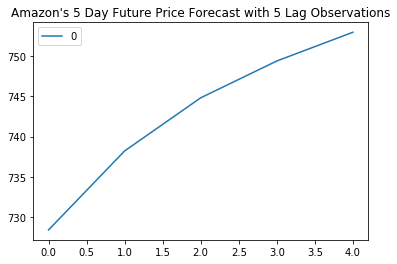

In [13]:
# Plot the 5 Day Price Forecast for Amazon for ARIMA model with 5 lag observations
pd.DataFrame(amzn_arima_results.forecast(steps=5)[0]).plot(title="Amazon's 5 Day Future Price Forecast with 5 Lag Observations")

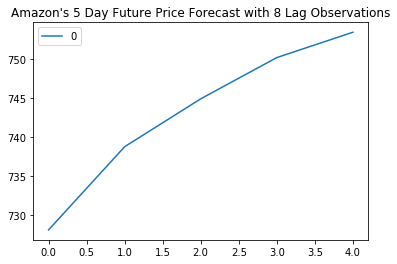

In [14]:
# Plot the 5 Day Price Forecast for Amazon for ARIMA model with 8 lag observations
pd.DataFrame(amzn_arima_results_2.forecast(steps=5)[0]).plot(title="Amazon's 5 Day Future Price Forecast with 8 Lag Observations")

In [15]:
# Create a series using Apple's price percentage returns, normalize, drop any nan"s, and check the results:
aapl_df = stock_df.loc[:,["AAPL"]]
aapl_daily_returns = stock_df.AAPL.pct_change() * 100
aapl_df["Return"] = np.log(aapl_daily_returns + 100)
aapl_df = aapl_df.replace(-np.inf, np.nan).dropna()
aapl_df.head()

,AAPL,Return
Date,,
2016-04-05,25.571972,4.593311
2016-04-06,25.839775,4.615588
2016-04-07,25.276215,4.583119
2016-04-08,25.304159,4.606275
2016-04-11,25.387993,4.608478


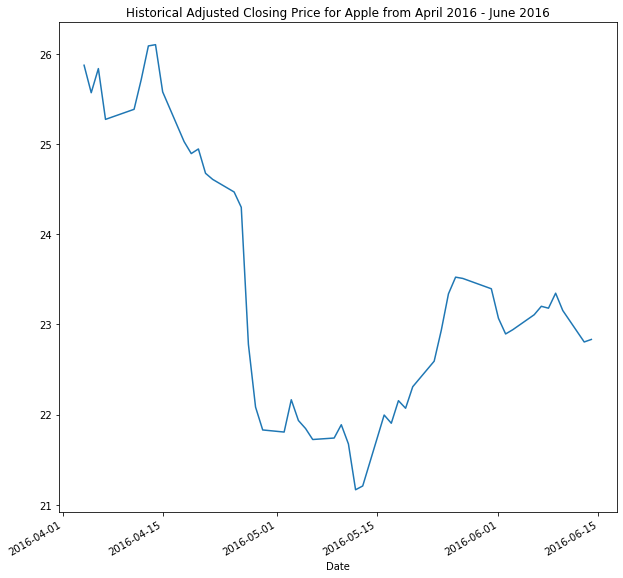

In [16]:
# plot historical adj close price for Apple
AAPL_plot = stock_df.AAPL.plot(title="Historical Adjusted Closing Price for Apple from April 2016 - June 2016", figsize=(10,10))

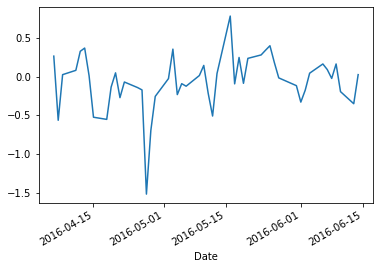

In [17]:
# Differencing AAPL adj close price stationarizes the time series
aapl_df.AAPL.diff().plot()

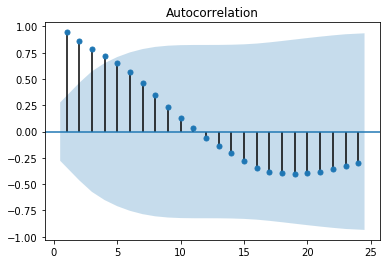

In [18]:
# Plot the autocorrelation of AAPL adj close prices
plot_acf(aapl_df.AAPL, zero=False, lags=24);

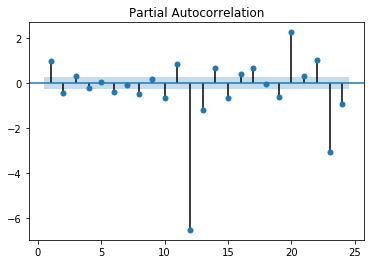

In [19]:
# Plot the partial autocorrelation of Apple's returns
plot_pacf(aapl_df.AAPL, zero=False, lags=24);

In [20]:
# Create a lagged return using the shift function
aapl_lag_return = aapl_df["Return"].shift()
aapl_df["Lagged Return"] = aapl_lag_return
aapl_df = aapl_df.replace(-np.inf, np.nan).dropna()
aapl_df.head()

,AAPL,Return,Lagged Return
Date,,,
2016-04-06,25.839775,4.615588,4.593311
2016-04-07,25.276215,4.583119,4.615588
2016-04-08,25.304159,4.606275,4.583119
2016-04-11,25.387993,4.608478,4.606275
2016-04-12,25.718679,4.618111,4.608478


In [21]:
# import sentiment data for Apple
aapl_sentiment_data = Path('../Merged_data/aapl_sentiment.csv')
aapl_sentiment = pd.read_csv(aapl_sentiment_data, index_col="Date", infer_datetime_format=True, parse_dates=True)
aapl_net_sentiment = aapl_sentiment.loc[:,["compound"]]
aapl_net_sentiment.head()

,compound
Date,
2016-04-02,0.121392
2016-04-03,0.069846
2016-04-04,0.076840
2016-04-05,0.074800
2016-04-06,0.123945


In [22]:
# create lagged sentiment data for Appe with shift function and add to the exisiting Apple dataframe
aapl_lagged_sentiment = aapl_net_sentiment.shift()
aapl_df["Lagged Sentiment"] = aapl_lagged_sentiment
aapl_df = aapl_df.dropna()
aapl_df.head()

,AAPL,Return,Lagged Return,Lagged Sentiment
Date,,,,
2016-04-06,25.839775,4.615588,4.593311,0.074800
2016-04-07,25.276215,4.583119,4.615588,0.123945
2016-04-08,25.304159,4.606275,4.583119,0.105394
2016-04-11,25.387993,4.608478,4.606275,0.096676
2016-04-12,25.718679,4.618111,4.608478,0.113251


In [23]:
# Estimate and ARIMA Model for Apple with 5 lagged observations:
aapl_arima_model = ARIMA(aapl_df.AAPL.values, order=(5,1,1))

# Fit the model
aapl_arima_results = aapl_arima_model.fit()

# Output model summary results:
aapl_arima_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                    D.y   No. Observations:                   44
Model:                 ARIMA(5, 1, 1)   Log Likelihood                 -13.833
Method:                       css-mle   S.D. of innovations              0.330
Date:                Fri, 22 Jan 2021   AIC                             43.666
Time:                        01:46:21   BIC                             57.940
Sample:                             1   HQIC                            48.959
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0750      0.083     -0.901      0.368      -0.238       0.088
ar.L1.D.y      0.9396      0.478      1.965      0.049       0.002       1.877
ar.L2.D.y     -0.2745      0.292     -0.942      0.346      -0.846       0.297
ar.L3.D.y     -0.1100      0.216     -0.508      0.611      -0.534       0.314
ar.L4.D.y      0.0876      0.225      0.389      0.697      -0.354       0.529
ar.L5.D.y      0.0851      0.164      0.518      0.605      -0.237       0.408
ma.L1.D.y     -0.5258      0.457     -1.151      0.250      -1.421       0.369
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.2470           -0.0000j            1.2470           -0.0000
AR.2            0.7404           -1.1018j            1.3274           -0.1558
AR.3            0.7404           +1.1018j            1.3274            0.1558
AR.4           -1.8781           -1.3485j            2.3121           -0.4009
AR.5           -1.8781           +1.3485j            2.3121            0.4009
MA.1            1.9020           +0.0000j            1.9020            0.0000
-----------------------------------------------------------------------------
"""

In [24]:
# Estimate and ARIMA Model for Apple with 8 lagged obersvations:
aapl_arima_model_2 = ARIMA(aapl_df.AAPL.values, order=(8,1,1))

# Fit the model
aapl_arima_results_2 = aapl_arima_model_2.fit()

# Output model summary results:
aapl_arima_results_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                    D.y   No. Observations:                   44
Model:                 ARIMA(8, 1, 1)   Log Likelihood                 -13.270
Method:                       css-mle   S.D. of innovations              0.325
Date:                Fri, 22 Jan 2021   AIC                             48.540
Time:                        01:46:23   BIC                             68.166
Sample:                             1   HQIC                            55.819
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0769      0.088     -0.875      0.381      -0.249       0.095
ar.L1.D.y      0.2649      1.626      0.163      0.871      -2.922       3.452
ar.L2.D.y     -0.0042      0.708     -0.006      0.995      -1.393       1.384
ar.L3.D.y     -0.1667      0.196     -0.850      0.395      -0.551       0.218
ar.L4.D.y      0.0070      0.287      0.024      0.981      -0.555       0.569
ar.L5.D.y      0.1198      0.162      0.739      0.460      -0.198       0.438
ar.L6.D.y     -0.0428      0.236     -0.182      0.856      -0.505       0.419
ar.L7.D.y      0.1476      0.180      0.821      0.412      -0.205       0.500
ar.L8.D.y      0.0670      0.309      0.217      0.829      -0.539       0.673
ma.L1.D.y      0.1551      1.624      0.095      0.924      -3.029       3.339
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.1950           -0.0000j            1.1950           -0.0000
AR.2            0.7712           -0.9146j            1.1963           -0.1385
AR.3            0.7712           +0.9146j            1.1963            0.1385
AR.4            0.0155           -1.3542j            1.3543           -0.2482
AR.5            0.0155           +1.3542j            1.3543            0.2482
AR.6           -1.1525           -0.6757j            1.3360           -0.4156
AR.7           -1.1525           +0.6757j            1.3360            0.4156
AR.8           -2.6669           -0.0000j            2.6669           -0.5000
MA.1           -6.4461           +0.0000j            6.4461            0.5000
-----------------------------------------------------------------------------
"""

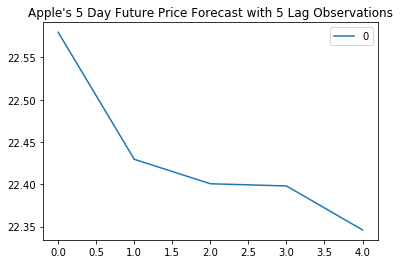

In [25]:
# Plot the 5 Day Price Forecast for Apple with 5 lagged observations
pd.DataFrame(aapl_arima_results.forecast(steps=5)[0]).plot(title="Apple's 5 Day Future Price Forecast with 5 Lag Observations")

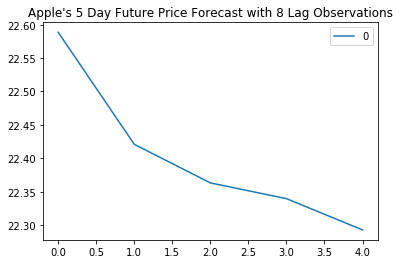

In [26]:
# Plot the 5 Day Price Forecast for Apple with 8 lagged observations
pd.DataFrame(aapl_arima_results_2.forecast(steps=5)[0]).plot(title="Apple's 5 Day Future Price Forecast with 8 Lag Observations")

In [27]:
# Create a series using Netflix price percentage returns, normalize, drop any nan"s, and check the results:
nflx_df = stock_df.loc[:,["NFLX"]]
nflx_daily_returns = stock_df.NFLX.pct_change() * 100
nflx_df["Return"] = np.log(nflx_daily_returns + 100)
nflx_df = nflx_df.replace(-np.inf, np.nan).dropna()
nflx_df.head()

,NFLX,Return
Date,,
2016-04-05,104.940002,4.610808
2016-04-06,104.830002,4.604121
2016-04-07,104.449997,4.601539
2016-04-08,103.809998,4.599024
2016-04-11,102.680000,4.594225


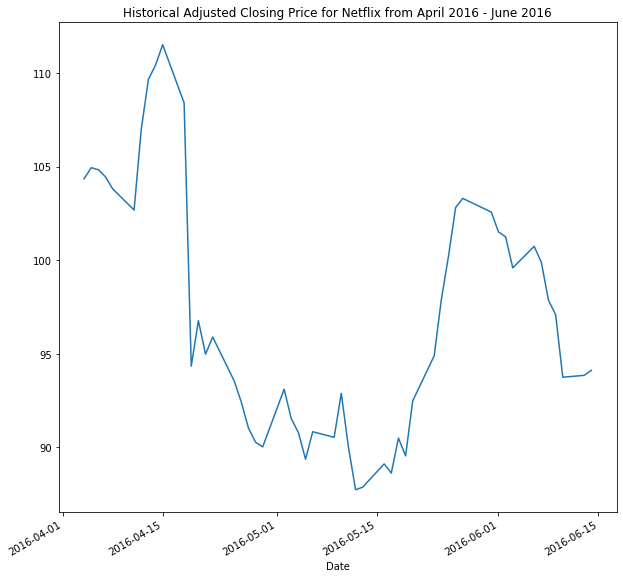

In [28]:
# plot historical adj close price for NFLX
NFLX_plot = stock_df.NFLX.plot(title="Historical Adjusted Closing Price for Netflix from April 2016 - June 2016", figsize=(10,10))

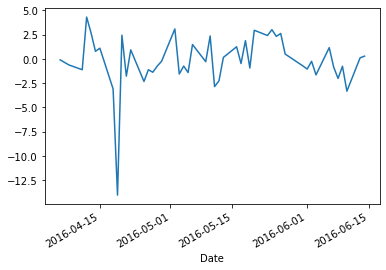

In [29]:
# Differencing NFLX adj close price stationarizes the time series
nflx_df.NFLX.diff().plot()

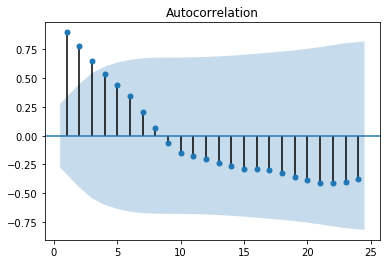

In [30]:
# Plot the autocorrelation of NFLX adj close prices
plot_acf(nflx_df.NFLX, zero=False, lags=24);

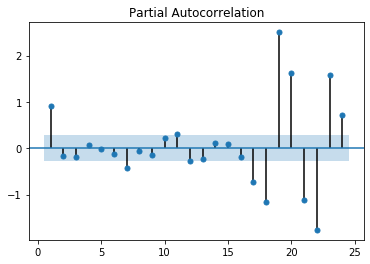

In [31]:
# Plot the partial autocorrelation of Netflix's returns
plot_pacf(nflx_df.NFLX, zero=False, lags=24);

In [32]:
# Create a lagged return using the shift function
nflx_lag_return = nflx_df["Return"].shift()
nflx_df["Lagged Return"] = nflx_lag_return
nflx_df = nflx_df.replace(-np.inf, np.nan).dropna()
nflx_df.head()

,NFLX,Return,Lagged Return
Date,,,
2016-04-06,104.830002,4.604121,4.610808
2016-04-07,104.449997,4.601539,4.604121
2016-04-08,103.809998,4.599024,4.601539
2016-04-11,102.680000,4.594225,4.599024
2016-04-12,106.980003,4.646195,4.594225


In [33]:
nflx_sentiment_data = Path('../Merged_data/ntflx_sentiment.csv')
nflx_sentiment = pd.read_csv(nflx_sentiment_data, index_col="Date", infer_datetime_format=True, parse_dates=True)
nflx_net_sentiment = nflx_sentiment.loc[:,["compound"]]
nflx_net_sentiment.head()

,compound
Date,
2016-03-31,0.067721
2016-04-01,0.130846
2016-04-02,0.114563
2016-04-03,0.107733
2016-04-04,0.086935


In [34]:
# create lagged sentiment with shift function for Netflix and add to the exisiting dataframe
nflx_lagged_sentiment = nflx_net_sentiment.shift()
nflx_df["Lagged Sentiment"] = nflx_net_sentiment
nflx_df = nflx_df.dropna()
nflx_df.head()

,NFLX,Return,Lagged Return,Lagged Sentiment
Date,,,,
2016-04-06,104.830002,4.604121,4.610808,0.069388
2016-04-07,104.449997,4.601539,4.604121,0.046270
2016-04-08,103.809998,4.599024,4.601539,0.091341
2016-04-11,102.680000,4.594225,4.599024,0.159414
2016-04-12,106.980003,4.646195,4.594225,0.174188


In [35]:
# Estimate and ARIMA Model with 5 lagged observations:
nflx_arima_model = ARIMA(nflx_df.NFLX.values, order=(5,1,1))

# Fit the model
nflx_arima_results = nflx_arima_model.fit()

# Output model summary results:
nflx_arima_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                    D.y   No. Observations:                   46
Model:                 ARIMA(5, 1, 1)   Log Likelihood                -111.528
Method:                       css-mle   S.D. of innovations              2.715
Date:                Fri, 22 Jan 2021   AIC                            239.056
Time:                        01:46:37   BIC                            253.685
Sample:                             1   HQIC                           244.536
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.2226      0.404     -0.551      0.582      -1.014       0.569
ar.L1.D.y     -0.7333      0.183     -4.015      0.000      -1.091      -0.375
ar.L2.D.y      0.1058      0.178      0.594      0.553      -0.243       0.455
ar.L3.D.y     -0.0054      0.182     -0.030      0.976      -0.362       0.352
ar.L4.D.y     -0.0668      0.185     -0.362      0.717      -0.429       0.295
ar.L5.D.y     -0.1786      0.156     -1.143      0.253      -0.485       0.128
ma.L1.D.y      0.8752      0.130      6.750      0.000       0.621       1.129
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.0269           -0.0000j            1.0269           -0.5000
AR.2           -0.8466           -1.2516j            1.5110           -0.3446
AR.3           -0.8466           +1.2516j            1.5110            0.3446
AR.4            1.1728           -1.0065j            1.5455           -0.1129
AR.5            1.1728           +1.0065j            1.5455            0.1129
MA.1           -1.1425           +0.0000j            1.1425            0.5000
-----------------------------------------------------------------------------
"""

In [36]:
# Estimate and ARIMA Modelwith 8 lagged observations:
nflx_arima_model_2 = ARIMA(nflx_df.NFLX.values, order=(8,1,1))

# Fit the model
nflx_arima_results_2 = nflx_arima_model_2.fit()

# Output model summary results:
nflx_arima_results_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                    D.y   No. Observations:                   46
Model:                 ARIMA(8, 1, 1)   Log Likelihood                -110.327
Method:                       css-mle   S.D. of innovations              2.577
Date:                Fri, 22 Jan 2021   AIC                            242.653
Time:                        01:46:39   BIC                            262.768
Sample:                             1   HQIC                           250.189
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1406      0.154     -0.915      0.360      -0.442       0.161
ar.L1.D.y      0.9898      0.151      6.547      0.000       0.693       1.286
ar.L2.D.y     -0.0282      0.201     -0.141      0.888      -0.422       0.365
ar.L3.D.y     -0.0978      0.195     -0.500      0.617      -0.481       0.285
ar.L4.D.y      0.0111      0.204      0.054      0.957      -0.388       0.410
ar.L5.D.y     -0.0584      0.204     -0.286      0.775      -0.458       0.341
ar.L6.D.y      0.3272      0.202      1.621      0.105      -0.068       0.723
ar.L7.D.y     -0.2826      0.208     -1.358      0.175      -0.691       0.125
ar.L8.D.y     -0.0458      0.171     -0.268      0.789      -0.381       0.289
ma.L1.D.y     -1.0000      0.072    -13.849      0.000      -1.142      -0.858
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0565           -0.2234j            1.0798           -0.0332
AR.2            1.0565           +0.2234j            1.0798            0.0332
AR.3            0.6349           -1.0042j            1.1881           -0.1603
AR.4            0.6349           +1.0042j            1.1881            0.1603
AR.5           -1.2101           -0.0000j            1.2101           -0.5000
AR.6           -0.5766           -1.0919j            1.2348           -0.3273
AR.7           -0.5766           +1.0919j            1.2348            0.3273
AR.8           -7.1938           -0.0000j            7.1938           -0.5000
MA.1            1.0000           +0.0000j            1.0000            0.0000
-----------------------------------------------------------------------------
"""

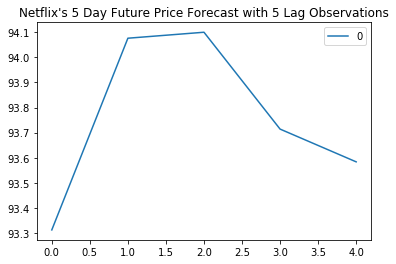

In [37]:
# Plot the 5 Day Price Forecast for Netflix with 5 lagged observations
pd.DataFrame(nflx_arima_results.forecast(steps=5)[0]).plot(title="Netflix's 5 Day Future Price Forecast with 5 Lag Observations")

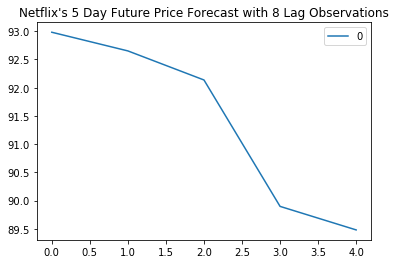

In [38]:
# Plot the 5 Day Price Forecast for Netflix with 8 lagged observations
pd.DataFrame(nflx_arima_results_2.forecast(steps=5)[0]).plot(title="Netflix's 5 Day Future Price Forecast with 8 Lag Observations")

In [39]:
amzn_df2 = stock_df.loc[:,["AMZN"]]
amzn_daily_returns2 = stock_df.AMZN.pct_change() * 100
amzn_df2["Return"] = amzn_daily_returns2
amzn_df2 = amzn_df2.replace(-np.inf, np.nan).dropna()
amzn_lag_return2 = amzn_df2["Return"].shift()
amzn_df2["Lagged Return"] = amzn_lag_return2
amzn_df2 = amzn_df2.replace(-np.inf, np.nan).dropna()
amzn_df2.head()

,AMZN,Return,Lagged Return
Date,,,
2016-04-06,602.080017,2.719487,-1.188487
2016-04-07,591.429993,-1.768872,2.719487
2016-04-08,594.599976,0.535986,-1.768872
2016-04-11,595.929993,0.223683,0.535986
2016-04-12,603.169983,1.214906,0.223683


In [40]:
# Create a train/test split for the data using  for testing and the rest for training to compare ARIMA vs standard 
amzn_train = amzn_df2[:'2016-05-05']
amzn_test = amzn_df2['2016-05-06':]

In [41]:
# Create four dataframes:
# X_amzn_train (training set using just the independent variables), X_amzn_test (test set of of just the independent variables)
# Y_amzn_train (training set using just the "y" variable), Y_amzn_test (test set of just the "y" variable):
X_amzn_train = amzn_train["Lagged Return"].to_frame()
X_amzn_test = amzn_test["Lagged Return"].to_frame()
y_amzn_train = amzn_train["Return"]
y_amzn_test = amzn_test["Return"]

In [42]:
# Preview the X_amzn_train data
X_amzn_train.head()

,Lagged Return
Date,
2016-04-06,-1.188487
2016-04-07,2.719487
2016-04-08,-1.768872
2016-04-11,0.535986
2016-04-12,0.223683


In [43]:
# Create a Linear Regression model and fit it to the training data
from sklearn.linear_model import LinearRegression

# Fit a SKLearn linear regression using  just the training set (X_amzn_train, Y_amzn_train):
amzn_model = LinearRegression()
amzn_model.fit(X_amzn_train, y_amzn_train)

LinearRegression()

In [44]:
# Make Amazon prediction of "y" values using just the test dataset
amzn_predictions = amzn_model.predict(X_amzn_test)

In [45]:
# Assemble actual y data (Y_amzn_test) with predicted y data into two columns in a dataframe:
amzn_results = y_amzn_test.to_frame()
amzn_results["Predicted Return"] = amzn_predictions

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fda7b158790>,
      dtype=object)

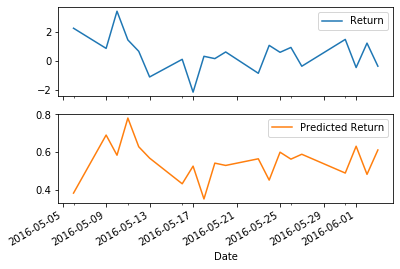

In [46]:
# Plot the first 20 Amazon predictions vs the true values
amzn_results[:20].plot(subplots=True)

In [47]:
# Out-of-Sample Performance
from sklearn.metrics import mean_squared_error
# Calculate the mean_squared_error (MSE) on actual versus predicted test "y" 
amzn_mse = mean_squared_error(
    amzn_results["Return"],
    amzn_results["Predicted Return"]
)

# Using that mean-squared-error, calculate the root-mean-squared error (RMSE):
amzn_out_of_sample_rmse = np.sqrt(amzn_mse)
print(f"Out-of-Sample Root Mean Squared Error (RMSE) for Amazon: {amzn_out_of_sample_rmse}")

Out-of-Sample Root Mean Squared Error (RMSE) for Amazon: 1.1367110437913377


In [48]:
aapl_df2 = stock_df.loc[:,["AAPL"]]
aapl_daily_returns2 = stock_df.AAPL.pct_change() * 100
aapl_df2["Return"] = aapl_daily_returns2
aapl_df2 = aapl_df2.replace(-np.inf, np.nan).dropna()
aapl_lag_return2 = aapl_df2["Return"].shift()
aapl_df2["Lagged Return"] = aapl_lag_return2
aapl_df2 = aapl_df2.replace(-np.inf, np.nan).dropna()
aapl_df2.head()

,AAPL,Return,Lagged Return
Date,,,
2016-04-06,25.839775,1.047253,-1.178903
2016-04-07,25.276215,-2.180981,1.047253
2016-04-08,25.304159,0.110557,-2.180981
2016-04-11,25.387993,0.331304,0.110557
2016-04-12,25.718679,1.302531,0.331304


In [49]:
# Create a train/test split for the data using  for testing and the rest for training to compare ARIMA vs standard 
aapl_train = aapl_df2[:'2016-05-05']
aapl_test = aapl_df2['2016-05-06':]

In [50]:
# Create four dataframes:
# X_aapl_train (training set using just the independent variables), X_aapl_test (test set of of just the independent variables)
# Y_aapl_train (training set using just the "y" variable), Y_aapl_test (test set of just the "y" variable):
X_aapl_train = aapl_train["Lagged Return"].to_frame()
X_aapl_test = aapl_test["Lagged Return"].to_frame()
y_aapl_train = aapl_train["Return"]
y_aapl_test = aapl_test["Return"]

In [51]:
# Preview the X_aapl_train data
X_aapl_train.head()

,Lagged Return
Date,
2016-04-06,-1.178903
2016-04-07,1.047253
2016-04-08,-2.180981
2016-04-11,0.110557
2016-04-12,0.331304


In [52]:
# Fit a SKLearn linear regression using  just the training set (X_aapl_train, Y_aapl_train):
aapl_model = LinearRegression()
aapl_model.fit(X_aapl_train, y_aapl_train)

LinearRegression()

In [53]:
# Make Apple prediction of "y" values using just the test dataset
aapl_predictions = aapl_model.predict(X_aapl_test)

In [54]:
# Assemble actual y data (Y_aapl_test) with predicted y data into two columns in a dataframe:
aapl_results = y_aapl_test.to_frame()
aapl_results["Predicted Return"] = aapl_predictions

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fda7b337640>,
      dtype=object)

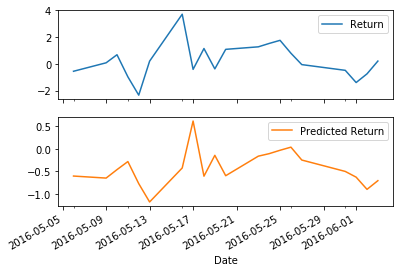

In [55]:
# Plot the first 20 Apple predictions vs the true values
aapl_results[:20].plot(subplots=True)

In [56]:
# Calculate the mean_squared_error (MSE) on actual versus predicted test "y" 
aapl_mse = mean_squared_error(
    aapl_results["Return"],
    aapl_results["Predicted Return"]
)

# Using that mean-squared-error, calculate the root-mean-squared error (RMSE):
aapl_out_of_sample_rmse = np.sqrt(aapl_mse)
print(f"Out-of-Sample Root Mean Squared Error (RMSE) for Apple: {aapl_out_of_sample_rmse}")

Out-of-Sample Root Mean Squared Error (RMSE) for Apple: 1.3064118157022506


In [57]:
nflx_df2 = stock_df.loc[:,["NFLX"]]
nflx_daily_returns2 = stock_df.NFLX.pct_change() * 100
nflx_df2["Return"] = nflx_daily_returns2
nflx_df2 = nflx_df2.replace(-np.inf, np.nan).dropna()
nflx_lag_return2 = nflx_df2["Return"].shift()
nflx_df2["Lagged Return"] = nflx_lag_return2
nflx_df2 = nflx_df2.replace(-np.inf, np.nan).dropna()
nflx_df2.head()

,NFLX,Return,Lagged Return
Date,,,
2016-04-06,104.830002,-0.104822,0.565409
2016-04-07,104.449997,-0.362496,-0.104822
2016-04-08,103.809998,-0.612733,-0.362496
2016-04-11,102.680000,-1.088525,-0.612733
2016-04-12,106.980003,4.187771,-1.088525


In [58]:
# Create a train/test split for the data using  for testing and the rest for training to compare ARIMA vs standard 
nflx_train = aapl_df2[:'2016-05-05']
nflx_test = aapl_df2['2016-05-06':]

In [59]:
# Create four dataframes:
# X_nflx_train (training set using just the independent variables), X_nflx_test (test set of of just the independent variables)
# Y_nflx_train (training set using just the "y" variable), Y_nflx_test (test set of just the "y" variable):
X_nflx_train = nflx_train["Lagged Return"].to_frame()
X_nflx_test = nflx_test["Lagged Return"].to_frame()
y_nflx_train = nflx_train["Return"]
y_nflx_test = nflx_test["Return"]

In [60]:
# Preview the X_nflx_train data
X_nflx_train.head()

,Lagged Return
Date,
2016-04-06,-1.178903
2016-04-07,1.047253
2016-04-08,-2.180981
2016-04-11,0.110557
2016-04-12,0.331304


In [61]:
# Fit a SKLearn linear regression using  just the training set (X_nflx_train, Y_nflx_train):
nflx_model = LinearRegression()
nflx_model.fit(X_nflx_train, y_nflx_train)

LinearRegression()

In [62]:
# Make Netflix prediction of "y" values using just the test dataset
nflx_predictions = nflx_model.predict(X_nflx_test)

In [63]:
# Assemble actual y data (Y_nflx_test) with predicted y data into two columns in a dataframe:
nflx_results = y_nflx_test.to_frame()
nflx_results["Predicted Return"] = nflx_predictions

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fda7b458b50>,
      dtype=object)

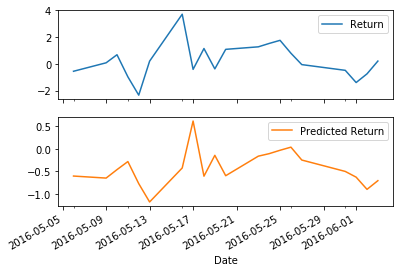

In [64]:
# Plot the first 20 Netflix predictions vs the true values
nflx_results[:20].plot(subplots=True)

In [65]:
# Calculate the mean_squared_error (MSE) on actual versus predicted test "y" 
nflx_mse = mean_squared_error(
    nflx_results["Return"],
    nflx_results["Predicted Return"]
)

# Using that mean-squared-error, calculate the root-mean-squared error (RMSE):
nflx_out_of_sample_rmse = np.sqrt(nflx_mse)
print(f"Out-of-Sample Root Mean Squared Error (RMSE) for Netflix: {nflx_out_of_sample_rmse}")

Out-of-Sample Root Mean Squared Error (RMSE) for Netflix: 1.3064118157022506


In [66]:
# In-Sample Performance
# Construct a dataframe using just the "y" training data:
amzn_in_sample_results = y_amzn_train.to_frame()

# Add a column of "in-sample" predictions to that dataframe:  
amzn_in_sample_results["In-sample Predictions"] = amzn_model.predict(X_amzn_train)

# Calculate in-sample mean_squared_error (for comparison to out-of-sample)
amzn_in_sample_mse = mean_squared_error(
    amzn_in_sample_results["Return"],
    amzn_in_sample_results["In-sample Predictions"]
)

# Calculate in-sample root mean_squared_error (for comparison to out-of-sample)
amzn_in_sample_rmse = np.sqrt(amzn_in_sample_mse)
print(f"In-sample Root Mean Squared Error (RMSE) for Amazon: {amzn_in_sample_rmse}")

In-sample Root Mean Squared Error (RMSE) for Amazon: 2.477248219662401


In [67]:
# Construct a dataframe using just the "y" training data:
aapl_in_sample_results = y_aapl_train.to_frame()

# Add a column of "in-sample" predictions to that dataframe:  
aapl_in_sample_results["In-sample Predictions"] = aapl_model.predict(X_aapl_train)

# Calculate in-sample mean_squared_error (for comparison to out-of-sample)
aapl_in_sample_mse = mean_squared_error(
    aapl_in_sample_results["Return"],
    aapl_in_sample_results["In-sample Predictions"]
)

# Calculate in-sample root mean_squared_error (for comparison to out-of-sample)
aapl_in_sample_rmse = np.sqrt(aapl_in_sample_mse)
print(f"In-sample Root Mean Squared Error (RMSE) for Apple: {aapl_in_sample_rmse}")

In-sample Root Mean Squared Error (RMSE) for Apple: 1.6277212465077104


In [68]:
# Construct a dataframe using just the "y" training data:
nflx_in_sample_results = y_nflx_train.to_frame()

# Add a column of "in-sample" predictions to that dataframe:  
nflx_in_sample_results["In-sample Predictions"] = nflx_model.predict(X_nflx_train)

# Calculate in-sample mean_squared_error (for comparison to out-of-sample)
nflx_in_sample_mse = mean_squared_error(
    nflx_in_sample_results["Return"],
    nflx_in_sample_results["In-sample Predictions"]
)

# Calculate in-sample root mean_squared_error (for comparison to out-of-sample)
nflx_in_sample_rmse = np.sqrt(nflx_in_sample_mse)
print(f"In-sample Root Mean Squared Error (RMSE) for Netflix: {nflx_in_sample_rmse}")

In-sample Root Mean Squared Error (RMSE) for Netflix: 1.6277212465077104
